In [ ]:
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
!pip install 'crewai[tools]'

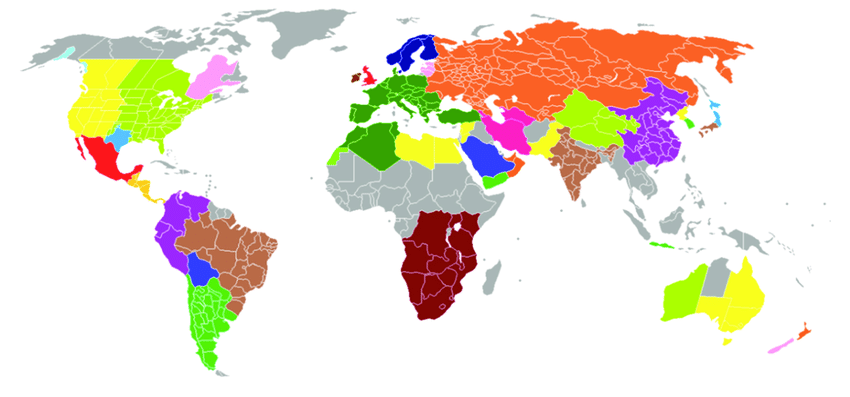

In [31]:
from IPython.display import Image
Image('./Map-of-synchronous-electricity-grids-in-different-parts-of-the-world.png')

In [8]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [9]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
EMAP_API_KEY= userdata.get('EMAP_API_KEY')

In [10]:
from crewai import Agent, Task, Crew

In [11]:
import os
openai_api_key = OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'

In [13]:
import crewai_tools
from crewai_tools import tool
import requests
import json
@tool("Carbon Intensity")
def carbon_break_up_tool_given_lat_long(latitude: float, longitude: float) -> str:
    """gives the carbon intensity values and break down given latitude and longitude of a location"""
    # Tool logic here
    # Iowa coordinates for this example
    #coordinates = {"lat": 41.9216734, "lon": -93.3122705}
    coordinates = {"lat": latitude, "lon": longitude}
    # API endpoint URL
    url= f"https://api.electricitymap.org/v3/carbon-intensity/latest?lon={coordinates['lon']}&lat={coordinates['lat']}"
    request = requests.get(url,
                       headers={"auth-token": EMAP_API_KEY},)
    return json.loads(request.content)

In [14]:
# Dictionary
VERTEX_REGIONS = [
    {"id": "northamerica-northeast1",
     "name": "Montréal",
     "lat": 45.5031824, "lon": -73.5698065},
    {"id": "us-central1",
     "name": "Iowa",
     "lat": 41.9216734, "lon": -93.3122705},
    {"id": "asia-south1",
     "name": "Mumbai",
     "lat": 19.0785451, "lon": 72.878176},
    {"id": "europe-west2",
     "name": "London",
     "lat": 51.5073219, "lon": -0.1276474},

]

vertex_region_str = str(VERTEX_REGIONS)
print(vertex_region_str)

[{'id': 'northamerica-northeast1', 'name': 'Montréal', 'lat': 45.5031824, 'lon': -73.5698065}, {'id': 'us-central1', 'name': 'Iowa', 'lat': 41.9216734, 'lon': -93.3122705}, {'id': 'asia-south1', 'name': 'Mumbai', 'lat': 19.0785451, 'lon': 72.878176}, {'id': 'europe-west2', 'name': 'London', 'lat': 51.5073219, 'lon': -0.1276474}]


In [15]:
carbon_intensity_agent = Agent(
    role="carbon intensity parse agent",
	goal="Be a professional carbon intensity parse agent, figure out how to look up json and know where to run the job with least carbon intensity. "
        "parse carbon intensity reports, use tools provided to you",
	backstory=(
		"You are expert in reading json carbon intensity reports and can figure out the location where we can run the job where carbon intensity is minimum, and expert in using tools provided to you."
	),
	allow_delegation=False,
	verbose=True
)

In [16]:
from crewai_tools import SerperDevTool, \
                         ScrapeWebsiteTool, \
                         WebsiteSearchTool

In [21]:
best_region_proposal_task = Task(
    description=(
        "Quickly do a thourough research for the following locations _____{vertex_region_str}: ____\n"
        "it is a string but underlying the string you will find names ofdifferent cities and their latitude and longitude "
		"Make sure to invoke tool for every region given to you and accumulate the results, then find out which value is the least in accumulated results."
    "You must strive to provide a complete "
        "and accurate response with all references"
    ),
    expected_output=(
	    "An informative response, so as to where to run the job, location and place name, what is the carbon intensity there."
    ),
	tools=[carbon_break_up_tool_given_lat_long],
    agent=carbon_intensity_agent,
)

In [22]:
crew = Crew(
  agents=[carbon_intensity_agent],
  tasks=[best_region_proposal_task],
  verbose=2,
  memory=True
)

In [23]:
inputs = {
    "vertex_region_str": "vertex_region_str"
}
result = crew.kickoff(inputs=inputs)

 [2024-08-04 17:11:05][DEBUG]: == Working Agent: carbon intensity parse agent
 [2024-08-04 17:11:05][INFO]: == Starting Task: Quickly do a thourough research for the following locations _____vertex_region_str: ____
it is a string but underlying the string you will find names ofdifferent cities and their latitude and longitude Make sure to invoke tool for every region given to you and accumulate the results, then find out which value is the least in accumulated results.You must strive to provide a complete and accurate response with all references


> Entering new CrewAgentExecutor chain...
I need to gather the latitude and longitude information for each of the cities in the given vertex_region_str and use the Carbon Intensity tool to find the carbon intensity values for each location. By accumulating the results, I can determine which location has the lowest carbon intensity.

Action: Carbon Intensity
Action Input: {"latitude": 51.5074, "longitude": 0.1278} 

{'zone': 'GB', 'carbonInte

In [24]:
from IPython.display import Markdown
Markdown(str(result))

Based on the carbon intensity values obtained, the location with the lowest carbon intensity is Paris, France with a carbon intensity of 22.